<a href="https://colab.research.google.com/github/yoojunT/ECEN758_GroupAssignment/blob/main/Fashion_MNIST_CNN_GradCAM_Code_Group35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion-MNIST Classification using CNN and Grad-CAM

> **Group members:** Yoojun Kim, Boyu Li, Changju Bak </br>
> **GitHub:** [GitHub Link](www.rsearch.com) </br>
> **Report:** [Report Link](www.rsearch.com) </br>
> **Blog:** [Blog Link](www.rsearch.com) </br>

## 1. Import Libraries and Define File Path

In [1]:
# Data hanlding
import pandas as pd
import numpy as np
import cv2

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from plotly.subplots import make_subplots
import plotly.offline as py
import plotly.io as pio
import plotly.graph_objs as go
from collections import defaultdict
from sklearn.metrics import confusion_matrix
!pip install umap-learn
import umap

#Tensorflow and Keras
import tensorflow as tf
print (tf.__version__) # check TensorFlow Version
from tensorflow.keras.datasets import fashion_mnist
from keras.callbacks import ModelCheckpoint

2.14.0


In [2]:
# Google colab
from google.colab import files
from google.colab import drive
drive.mount('/content/drive/') # Google Drive

# define your file path: where you want to save your results
result_path = '/content/drive/MyDrive/Colab Notebooks/result'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<a id="1"></a>
##  2. Data Load

In [3]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the images to have pixel values between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0


### 2.1. Descriptive Statistics

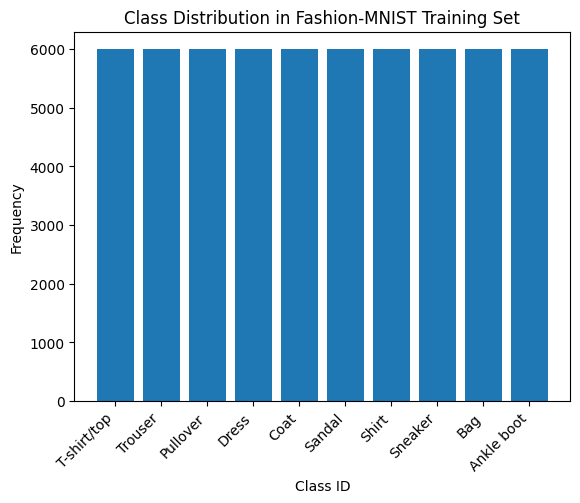

In [4]:
# Count the number of instances in each class
unique, counts = np.unique(train_labels, return_counts=True)
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
# Visualize the distribution of classes
plt.bar(unique, counts)
plt.title('Class Distribution in Fashion-MNIST Training Set')
plt.xlabel('Class ID')
plt.ylabel('Frequency')
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.show()


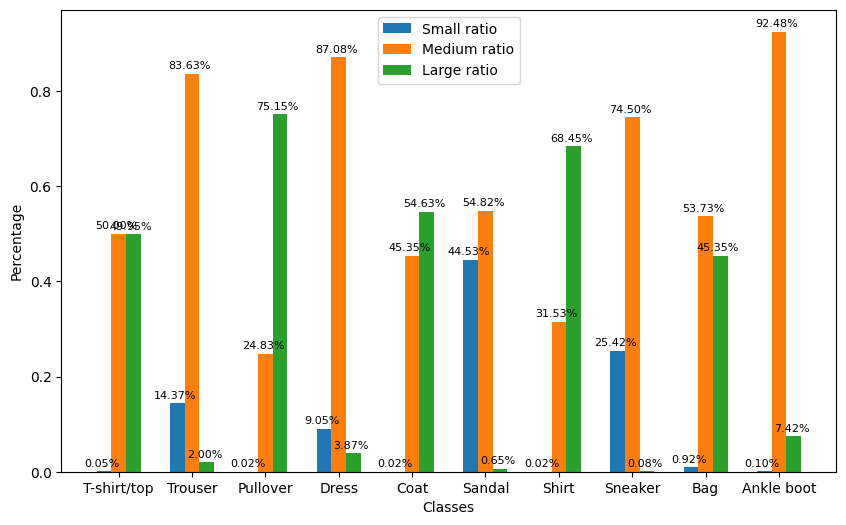

In [5]:
# Load the Fashion MNIST dataset and split it into training and testing sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to a range between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define a function to calculate the non-background pixel ratio for a list of images
def calculate_non_background_ratio(images):
    total_pixels = 28 * 28  # Total number of pixels in each image (28x28)
    ratios = [np.count_nonzero(image) / total_pixels for image in images]
    return ratios

# Calculate non-background pixel ratios for the training dataset
ratios = calculate_non_background_ratio(x_train)

# Define class names for Fashion MNIST dataset
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Create a dictionary to store non-background pixel ratios for each class
class_ratios = {i: [] for i in range(10)}

# Populate the class_ratios dictionary with ratios for each class
for ratio, label in zip(ratios, y_train):
    class_ratios[label].append(ratio)

# Initialize an empty list to store category information for each class
class_category = []

# Define three categories based on pixel ratios: Small ratio, Medium ratio, Large ratio
for i in range(10):
    category = [0, 0, 0]  # Initialize counts for each category
    for item in class_ratios[i]:
        if item < 0.3:
            category[0] += 1
        elif 0.3 <= item < 0.6:
            category[1] += 1
        else:
            category[2] += 1
    # Normalize the counts by dividing by the total number of samples (6000)
    category = np.array(category) / 6000
    class_category.append(list(category))

# Define categories for the bar chart
categories = ["Small ratio", "Medium ratio", "Large ratio"]

# Create a bar chart to visualize the class distribution in different categories
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
bar_positions = np.arange(len(class_names))

# Plot bars for each category
for i, category in enumerate(categories):
    bars = [class_category[j][i] for j in range(len(class_names))]
    ax.bar(bar_positions + i * bar_width, bars, width=bar_width, label=category)

# Add percentage labels on top of each bar
for i, xpos in enumerate(bar_positions):
    for j, category in enumerate(categories):
        value = class_category[i][j]
        ax.text(xpos + j * bar_width - 0.03, value + 0.01, f"{value:.2%}", fontsize=8, color='black', ha='center')

# Set labels and legend for the plot
ax.set_xticks(bar_positions + bar_width)
ax.set_xticklabels(class_names)
ax.set_xlabel('Classes')
ax.set_ylabel('Percentage')
ax.legend(loc='upper center')

# Show the bar chart
plt.show()

<a id="13"></a>
### 2.2. Visualization

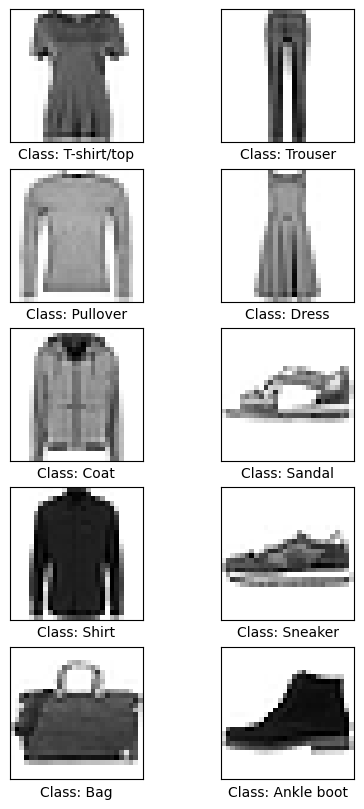

In [6]:
# Plotting examples from each class
num_classes = len(np.unique(train_labels))
plt.figure(figsize=(5, 10))
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
for i in range(num_classes):
    # Find an image in the training set with the label i
    img = train_images[train_labels == i][3]
    plt.subplot(5, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel("Class: %s" % class_names[i])

plt.show()

> We use the dimension reduction using UMAP as a means of data visualization to better understand the data attritues with the below code. The result is as below:


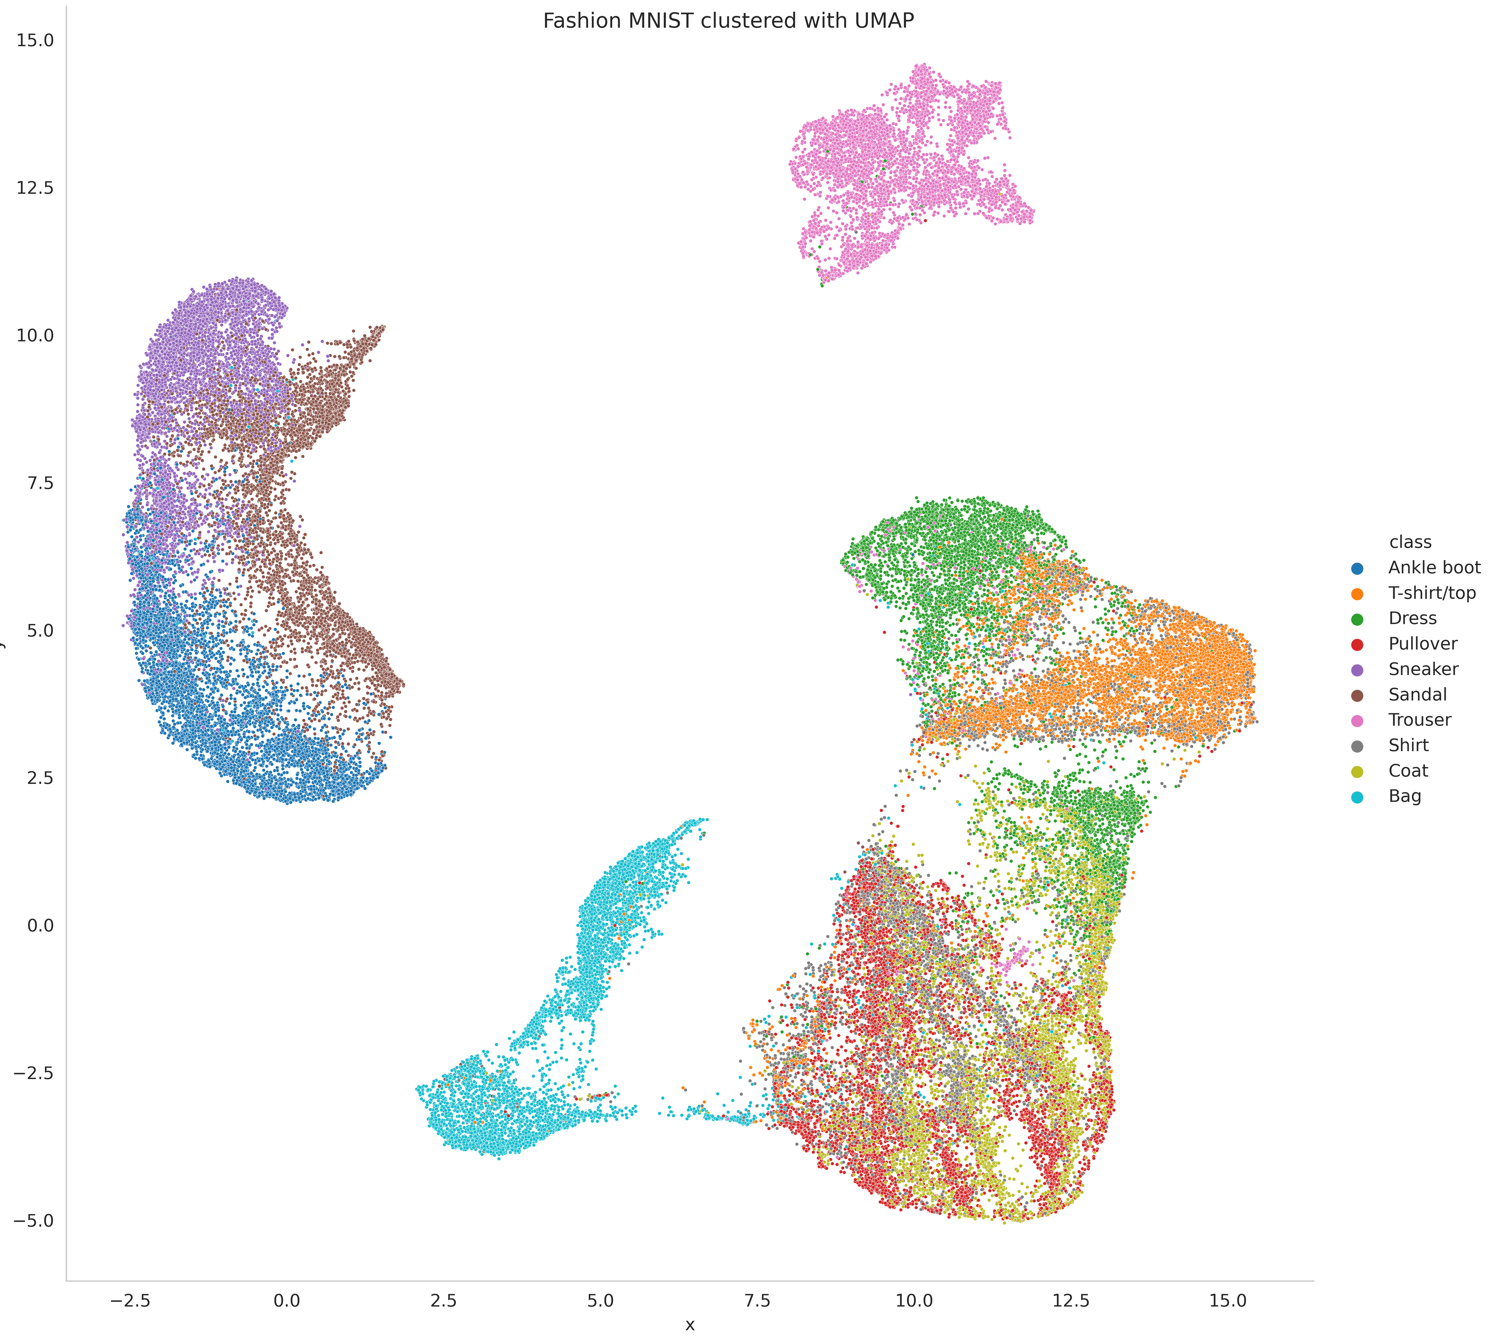


In [7]:
### UMAP Code

# # Load the Fashion MNIST dataset and only keep the training data
# (x_train, y_train), (_, _) = fashion_mnist.load_data()

# # Reshape the training data into a 2D array of shape (number of samples, number of features)
# data = x_train.reshape(x_train.shape[0], -1).astype(np.float32)
# target = y_train

# # Initialize UMAP (Uniform Manifold Approximation and Projection) with a random state
# reduce = umap.UMAP(random_state=0)

# # Use UMAP to create a low-dimensional embedding of the data
# embedding = reduce.fit_transform(data)

# # Create a Pandas DataFrame to store the embedded data with columns 'x' and 'y'
# df = pd.DataFrame(embedding, columns=('x', 'y'))

# # Add a 'class' column to the DataFrame to store target labels
# df["class"] = target

# # Define a mapping of class labels to class names
# labels = {
#     0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
#     5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
# }

# # Replace numerical class labels with corresponding class names
# df["class"].replace(labels, inplace=True)

# # Set the style for the Seaborn pairplot (white grid with no axis grid lines)
# sns.set_style("whitegrid", {'axes.grid': False})

# # Create a pairplot to visualize the low-dimensional embedding, with points colored by class
# ax = sns.pairplot(x_vars=["x"], y_vars=["y"], data=df,
#                   hue="class", height=11, plot_kws={"s": 4})

# # Set the title for the pairplot
# ax.fig.suptitle('Fashion MNIST clustered with UMAP')

# # save the figure
# ax.savefig(f'{result_path}/UMAP.png', dpi=500)
# plt.show()

##  3. Experiments

### 3.1. Data Spliting

In [8]:
# data Load
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# raw train and data set size
print(x_train.shape[0], 'train set')
print(x_test.shape[0], 'test set')

x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_train shape: (60000, 28, 28) y_train shape: (60000,)
60000 train set
10000 test set


In [9]:
# class names
class_names = ["T-shirt/top",  # Index 0
               "Trouser",      # Index 1
               "Pullover",     # Index 2
               "Dress",        # Index 3
               "Coat",         # Index 4
               "Sandal",       # Index 5
               "Shirt",        # Index 6
               "Sneaker",      # Index 7
               "Bag",          # Index 8
               "Ankle boot"]   # Index 9

# print some example
img_index = 1
label_index = y_train[img_index]
print ("y = " + str(label_index) + " " +(class_names[label_index]))

y = 0 T-shirt/top


In [10]:
# scale the values to a range of 0 to 1 of both data sets
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [11]:
# split the data into train/valdiation (train: 55,000, validation: 5000)
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# reshpe the input image size from (28, 28) to (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# one-hot Encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# print size of train set
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# print number of train/validation/test image dataset
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

x_train shape: (55000, 28, 28, 1) y_train shape: (55000, 10)
55000 train set
5000 validation set
10000 test set


### 3.2. Model Building

In [12]:
model = tf.keras.Sequential()

# CNN architerue design
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

In [13]:
# compile the model
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

> Below cell is actual code for our model training with epochs of 50. </br>
> Based on this result, we select our best model at epochs of 39 (See our report) </br>
> Here, we set epoch as 1 to meet the requirement of code preparation.



In [14]:
# # training
# checkpointer = ModelCheckpoint(filepath=f'{result_path}/model.weights.best.hdf5', verbose = 1, save_best_only=True)
# history = model.fit(x_train,
#                     y_train,
#                     batch_size=64,
#                     epochs=50,
#                     validation_data=(x_valid, y_valid),
#                     callbacks=[checkpointer])

# # plot training & validation loss values
# plt.plot(history.history['loss'], 'blue')
# plt.plot(history.history['val_loss'], 'orange')
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# # save the figure
# plt.savefig(f'{result_path}/model_loss.png', dpi=500)

# plt.show()

# # plot accuracy results for training data and testing data
# plt.plot(history.history['accuracy'], 'green')
# plt.plot(history.history['val_accuracy'], 'red')
# plt.title('Model accuracy ')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# # save the figure
# plt.savefig(f'{result_path}/model_accuracy.png', dpi=500)

# plt.show()

In [15]:
# training
checkpointer = ModelCheckpoint(filepath=f'{result_path}/model.weights.best.hdf5', verbose = 1, save_best_only=True)
history = model.fit(x_train,
                    y_train,
                    batch_size=64,
                    epochs=1,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer])

859/860 [============================>.] - ETA: 0s - loss: 0.5578 - accuracy: 0.7972
Epoch 1: val_loss improved from inf to 0.39359, saving model to /content/drive/MyDrive/Colab Notebooks/result/model.weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



860/860 [==============================] - 75s 86ms/step - loss: 0.5578 - accuracy: 0.7972 - val_loss: 0.3936 - val_accuracy: 0.8716


In [16]:
# load the best model
model.load_weights(f'{result_path}/model.weights.best.hdf5')

### 3.3. Model Evaluation

In [17]:
## Accuracy

# evaluation on test dataset
score = model.evaluate(x_test, y_test, verbose=0)

# test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8579999804496765


In [18]:
# y_hat: prediction results on test datset
y_hat = model.predict(x_test)

313/313 [==============================] - 4s 12ms/step


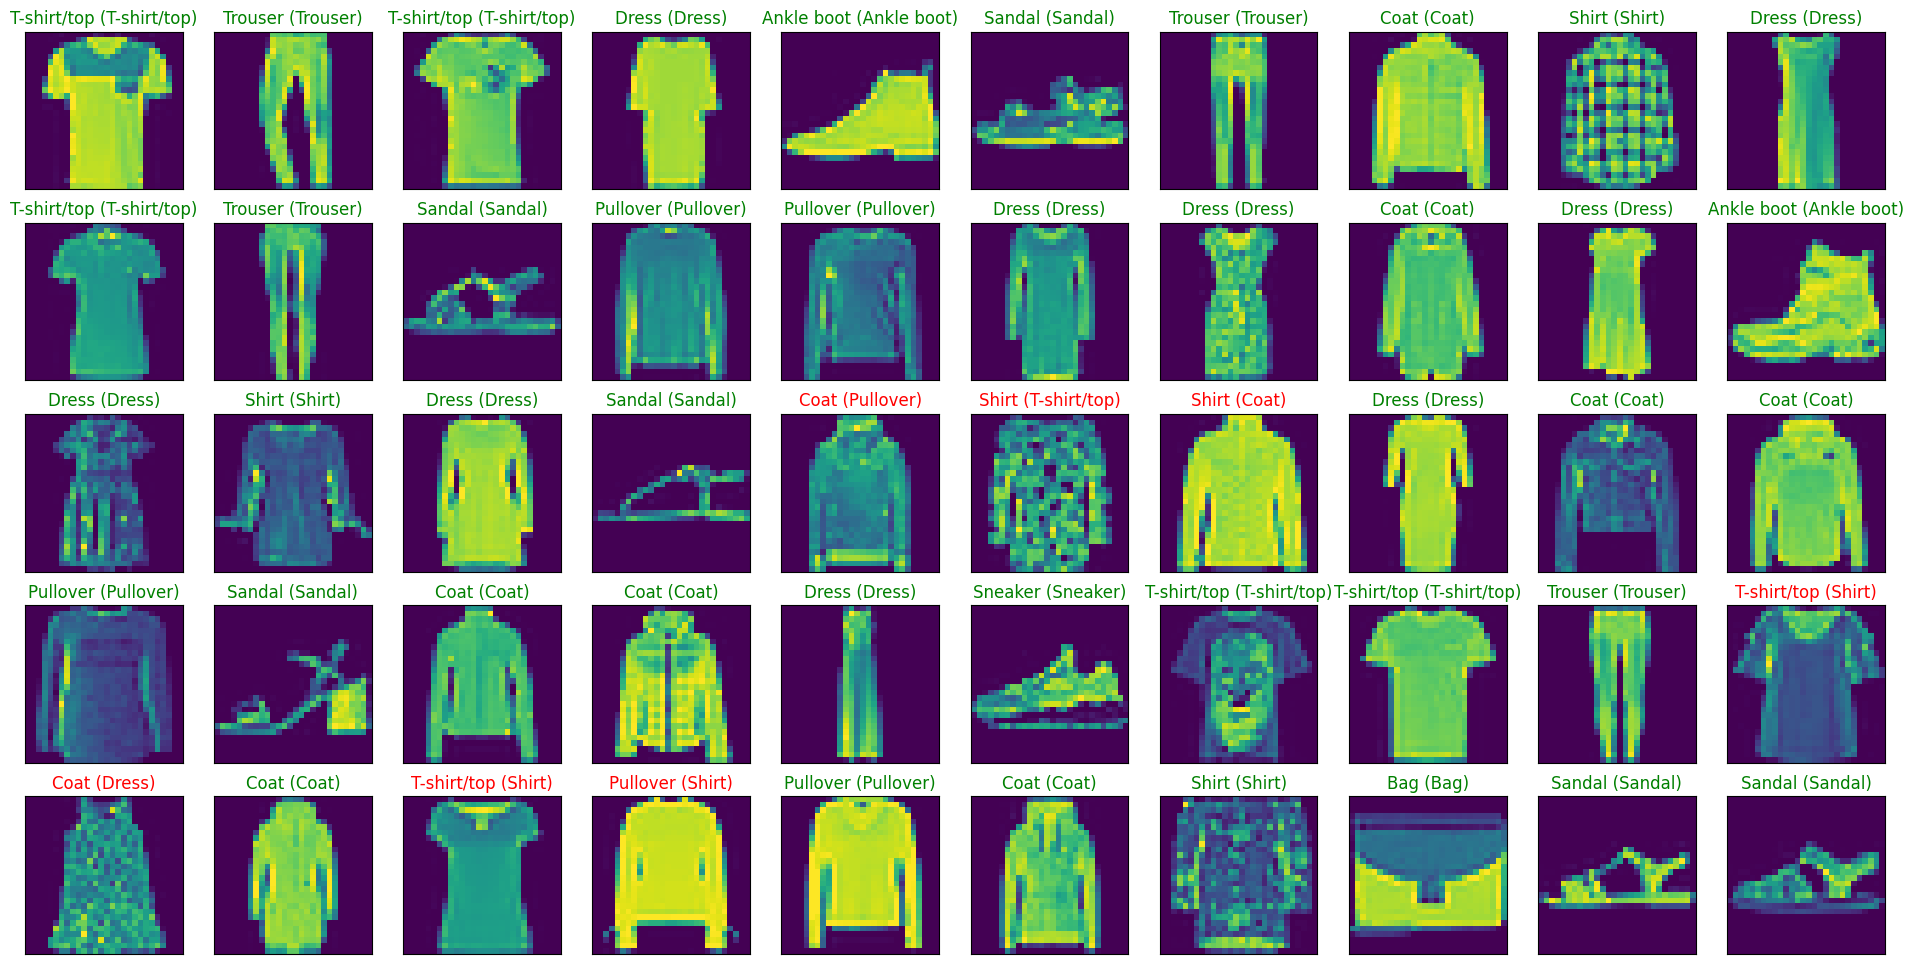

In [19]:
# display random 10 smapling for the test results
figure = plt.figure(figsize=(24, 12))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=50, replace=False)):
    ax = figure.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    ax.set_title("{} ({})".format(class_names[predict_index],
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

# save the figure
plt.savefig(f'{result_path}/test_results_visualization.png', dpi=500)

plt.show()

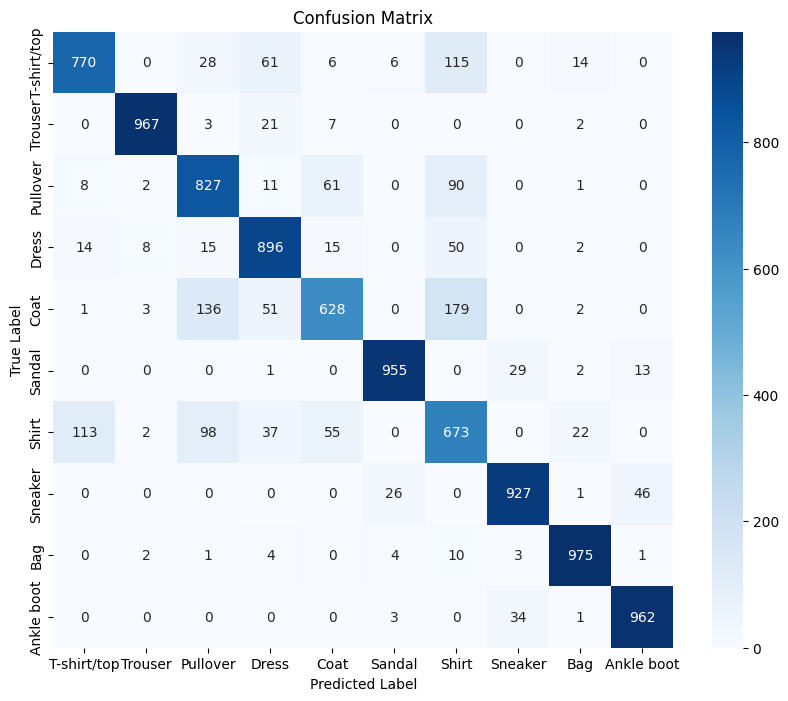

In [20]:
## Confusion Matrix

# convert predictions and true labels to label indices if they are in one-hot encoded form
y_pred_labels = np.argmax(y_hat, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# save the figure
plt.savefig(f'{result_path}/confusion_matrix.png', dpi=500)

plt.show()

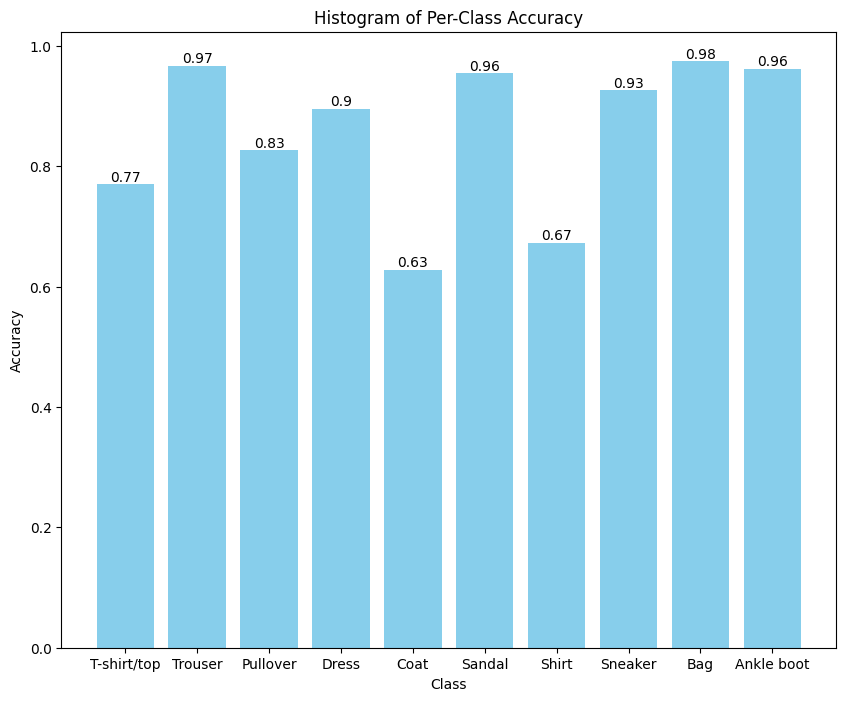

In [21]:
# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# plotting the histogram of per-class accuracy
plt.figure(figsize=(10, 8))
bars = plt.bar(class_names, class_accuracy, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Histogram of Per-Class Accuracy')

# annotating each bar with its accuracy value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# save the figure
plt.savefig(f'{result_path}/per_class_accuracy_histogram.png', dpi=500)

plt.show()

### 3.4 GradCAM as XAI

In [22]:
# GradCAM

def generate_gradcam(img, model, class_idx, last_conv_layer_name):
    img_reshaped = np.reshape(img, (1, 28, 28, 1))

    # Get the output of the last convolutional layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_output = last_conv_layer.output

    # Model that maps from model inputs to the last conv layer output
    grad_model = tf.keras.Model([model.inputs], [last_conv_layer.output, model.output])

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_reshaped)
        loss = predictions[:, class_idx]

    # Gradients with respect to the last conv layer output
    grads = tape.gradient(loss, conv_outputs)

    # Mean intensity of the gradient over the feature map axis
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Reshape for correct broadcasting
    pooled_grads = tf.reshape(pooled_grads, [1, 1, len(pooled_grads)])

    # Weigh the output feature map with these gradients
    conv_outputs = conv_outputs[0]
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Process the class activation map for visualization
    cam = np.maximum(cam, 0)  # ReLU
    cam = cam / tf.reduce_max(cam)  # Normalize
    cam = cv2.resize(cam.numpy(), (28, 28))

    return cam

1/1 [==============================] - 0s 40ms/step


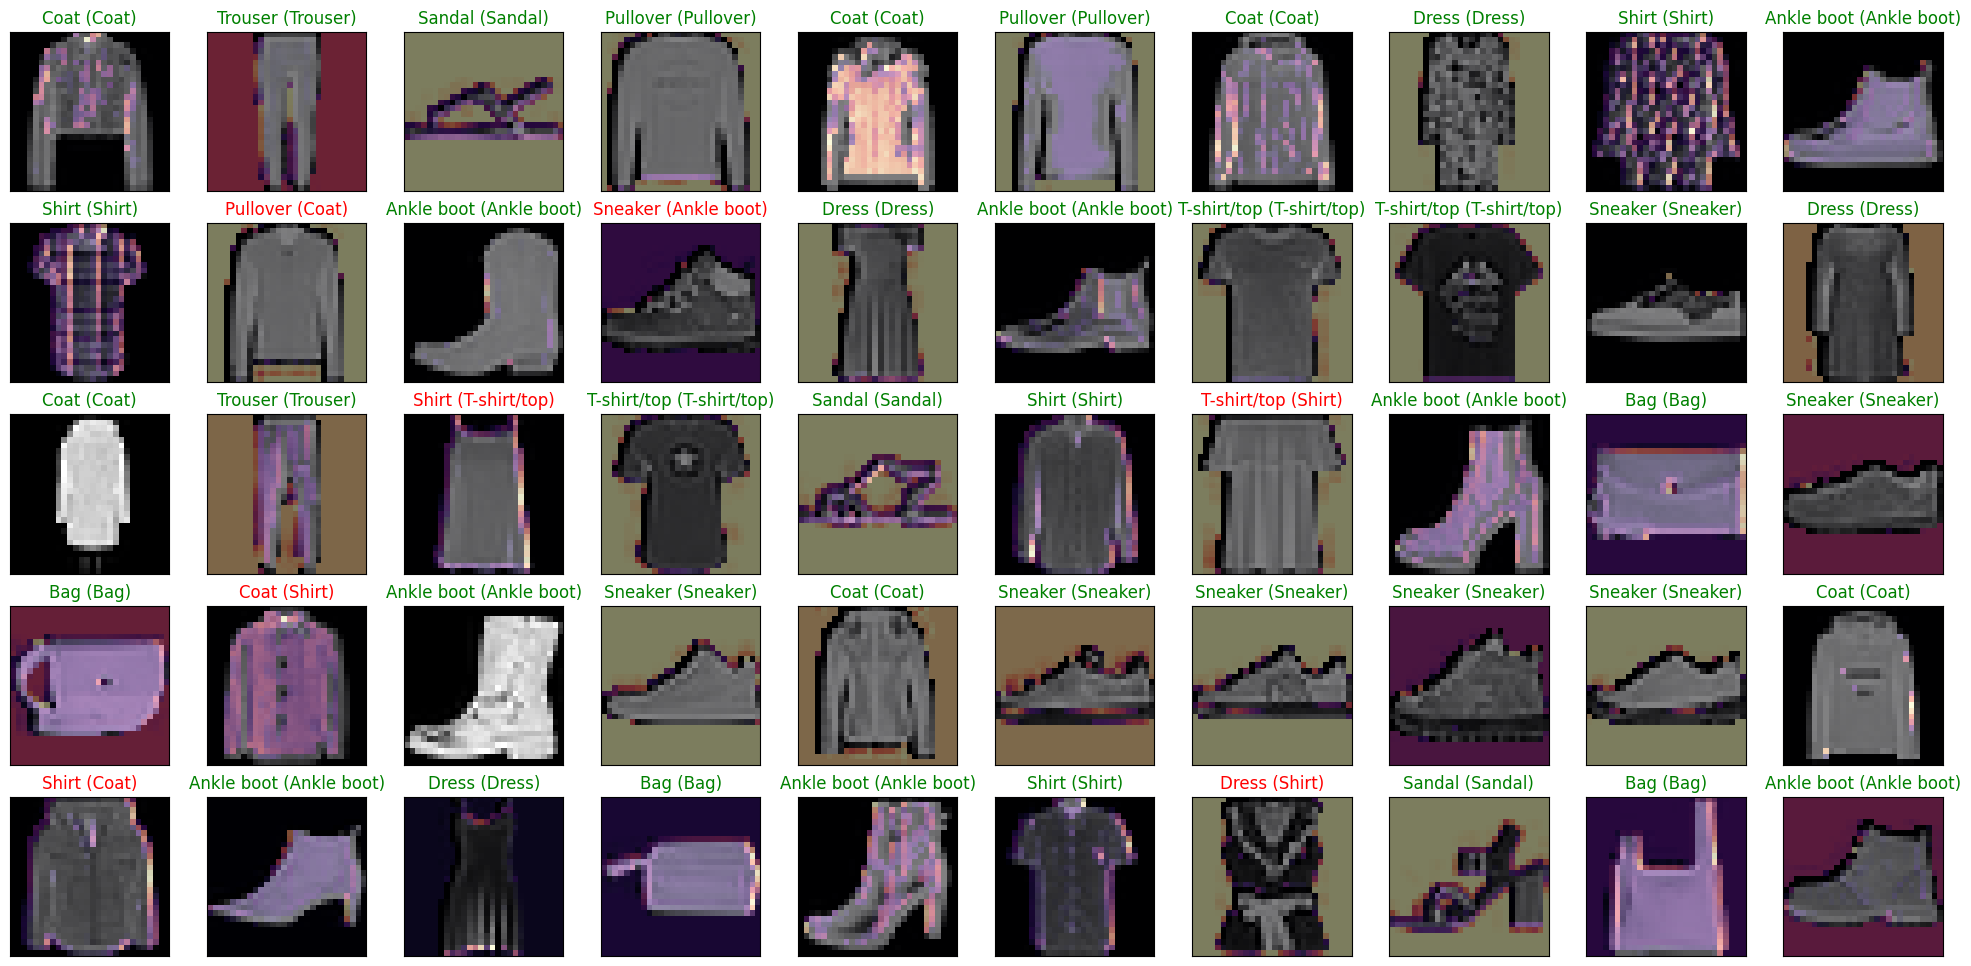

In [23]:
# random sampling for test results visualization
figure = plt.figure(figsize=(25, 12))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=50, replace=False)):
    ax = figure.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]), cmap='gray')

    # GradCAM for the current image
    last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
    preds = model.predict(np.reshape(x_test[index], (1, 28, 28, 1)))
    class_idx = np.argmax(preds[0])
    gradcam = generate_gradcam(x_test[index], model, class_idx, last_conv_layer_name)

    ax.imshow(gradcam, cmap='magma', alpha=0.5)

    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    ax.set_title("{} ({})".format(class_names[predict_index],
                                  class_names[true_index]),
                 color=("green" if predict_index == true_index else "red"))

# save the figure
figure.savefig(f'{result_path}/GradCAM_50.png', dpi=500)

plt.show()

1/1 [==============================] - 0s 34ms/step


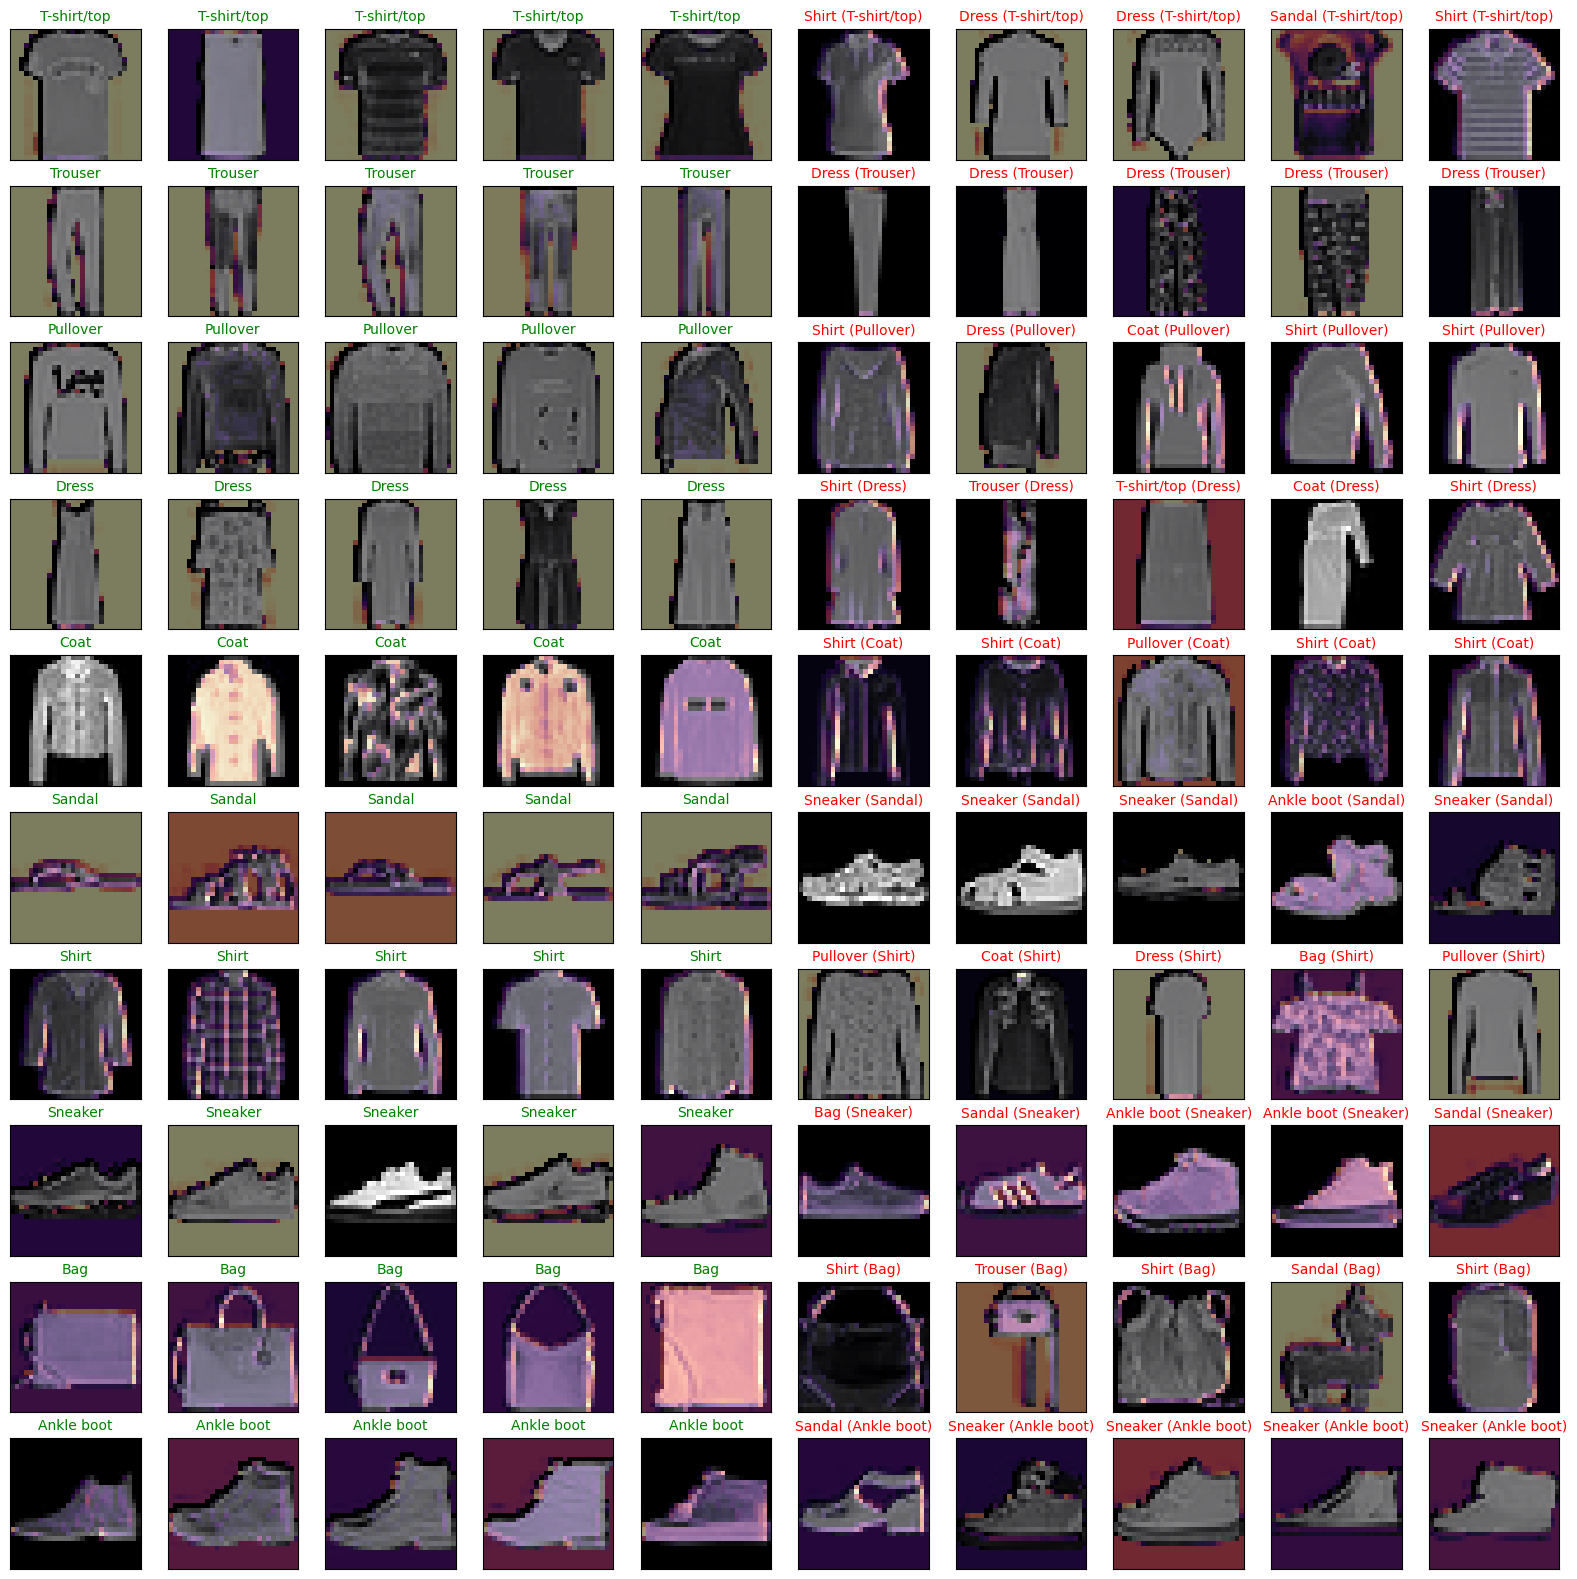

In [24]:
# misclassified and correctly classified images
misclassified_indices = np.where(np.argmax(y_hat, axis=1) != np.argmax(y_test, axis=1))[0]
correctly_classified_indices = np.where(np.argmax(y_hat, axis=1) == np.argmax(y_test, axis=1))[0]

misclassified_true_labels = np.argmax(y_test[misclassified_indices], axis=1)
correctly_classified_true_labels = np.argmax(y_test[correctly_classified_indices], axis=1)

# misclassified and correctly classified image by class
misclassified_by_class = {class_id: [] for class_id in range(10)}
correctly_classified_by_class = {class_id: [] for class_id in range(10)}

for index, true_label in zip(misclassified_indices, misclassified_true_labels):
    misclassified_by_class[true_label].append(index)

for index, true_label in zip(correctly_classified_indices, correctly_classified_true_labels):
    correctly_classified_by_class[true_label].append(index)

# plotting
figure, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))

for row, class_id in enumerate(range(10)):
    # 5 correctly classified images for the current class
    sample_indices_correct = correctly_classified_by_class[class_id][:5]
    for col, index in enumerate(sample_indices_correct):
        ax = axes[row, col]
        ax.imshow(np.squeeze(x_test[index]), cmap='gray')

        #GradCAM
        gradcam = generate_gradcam(x_test[index], model, class_id, last_conv_layer_name)

        ax.imshow(gradcam, cmap='magma', alpha=0.5)

        #title
        ax.set_title("{}".format(class_names[class_id]), color="green", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

    # 5 misclassified images for the current class
    sample_indices = misclassified_by_class[class_id][:5]
    for col, index in enumerate(sample_indices, start=5):  # Start from the 6th column
        ax = axes[row, col]
        ax.imshow(np.squeeze(x_test[index]), cmap='gray')
        last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
        preds = model.predict(np.reshape(x_test[index], (1, 28, 28, 1)))
        class_idx = np.argmax(preds[0])

        #GradCAM
        gradcam = generate_gradcam(x_test[index], model, class_idx, last_conv_layer_name)
        ax.imshow(gradcam, cmap='magma', alpha=0.5)
        predict_index = np.argmax(y_hat[index])
        true_index = np.argmax(y_test[index])

        #title
        ax.set_title("{} ({})".format(class_names[predict_index], class_names[true_index]),
                     color=("green" if predict_index == true_index else "red"), fontsize=10)

        ax.set_xticks([])
        ax.set_yticks([])

# save the figure
figure.savefig(f'{result_path}/GradCAM_Classified_10_per_class.png', dpi=500)
plt.show()

1/1 [==============================] - 0s 27ms/step


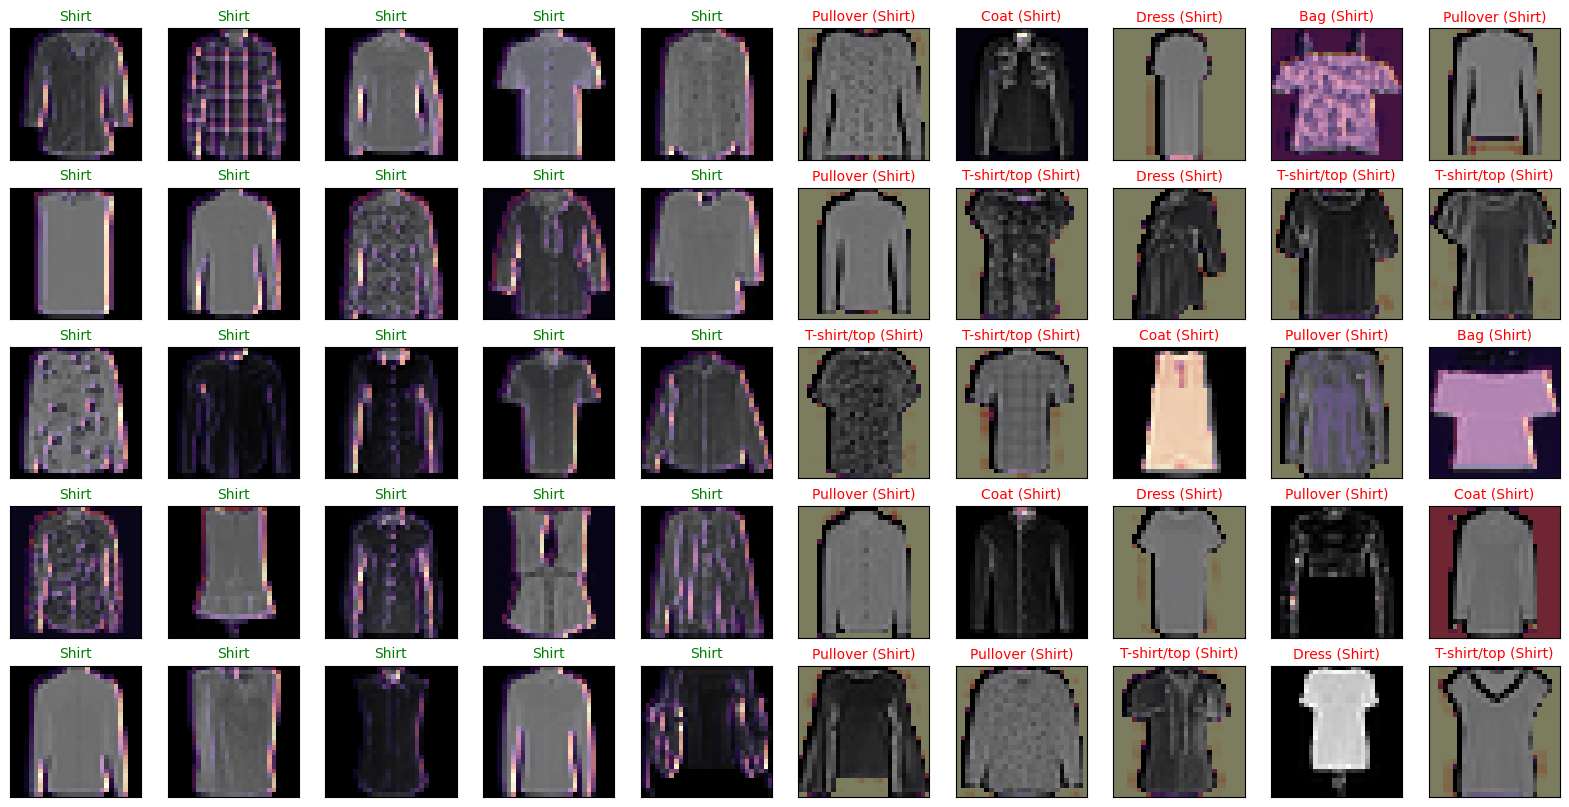

In [25]:
# Find correctly classified images where the true label is "Shirt" (index 6)
shirt_correct_indices = [index for index in correctly_classified_indices if np.argmax(y_test[index]) == 6]

# Find misclassified images where the true label is "Shirt" (index 6)
shirt_misclassified_indices = [index for index in misclassified_indices if np.argmax(y_test[index]) == 6]

# Plotting
figure, axes = plt.subplots(nrows=5, ncols=10, figsize=(20, 10))  # Adjusted for 5 rows and 10 columns

# correctly classified "Shirt" images in the first 5 columns
for i, index in enumerate(shirt_correct_indices[:25]):  # Limit to the first 25 correctly classified "Shirt" images
    row, col = divmod(i, 5)
    ax = axes[row, col]
    ax.imshow(np.squeeze(x_test[index]), cmap='gray')

    #GradCAM
    gradcam = generate_gradcam(x_test[index], model, 6, last_conv_layer_name)

    ax.imshow(gradcam, cmap='magma', alpha=0.5)
    ax.set_title("Shirt", color="green", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

# misclassified "Shirt" images in the last 5 columns
for i, index in enumerate(shirt_misclassified_indices[:25]):  # Limit to the first 25 misclassified "Shirt" images
    row, col = divmod(i, 5)
    ax = axes[row, col + 5]  # Start from the 6th column
    ax.imshow(np.squeeze(x_test[index]), cmap='gray')

    #GradCAM
    last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
    preds = model.predict(np.reshape(x_test[index], (1, 28, 28, 1)))
    class_idx = np.argmax(preds[0])
    gradcam = generate_gradcam(x_test[index], model, class_idx, last_conv_layer_name)

    ax.imshow(gradcam, cmap='magma', alpha=0.5)
    predict_index = np.argmax(y_hat[index])
    ax.set_title("{} (Shirt)".format(class_names[predict_index]), color="red", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

# save the figure
figure.savefig(f'{result_path}/GradCAM_Correct_and_Misclassified_Shirts.png', dpi=500)
plt.show()

## Code Reference

    > https://www.kaggle.com/code/nulldata/tsne-alternate-umap-3d-viz-on-fashion-mnist
    > https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb#scrollTo=xvwvpA64CaW_
    > https://github.com/KerasKorea/KEKOxTutorial/blob/master/10_Fashion-MNIST%20with%20tf.Keras
    > https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/
    > https://github.com/teddylee777/machine-learning/blob/master/08-XAI/CAM.ipynb
